# Walktrough: Cross-Compound Analysis

In this tutorial, we compare the **geometrical space explored during photoinduced dynamics** for a series of related molecular systems: three alkenes, $ \mathrm{C}_n\mathrm{H}_{2n} $ with $ n = 2, 3, 4 $, and the compound **I01**, methyleneimmonium ($\mathrm{CH_2NH_2^+}$), which is **isoelectronic to ethene**.

We demonstrate how to **select matching substructures** across different molecules in order to define **comparable, geometry-based descriptors**. These descriptors are then processed and analyzed using **principal component analysis (PCA)** to reduce the dimensionality from six internal coordinates to two, enabling clear and intuitive visualization of the sampled configuration space.

> **Important**: 
> Note, the data of the tutorial is described in [Sci Data 2025, 12, 1300](https://www.nature.com/articles/s41597-025-05443-5) and available on [Zenodo](https://doi.org/10.5281/zenodo.15482819) and not provided in the shnitsel-tools repository.

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt

import shnitsel as st
import shnitsel.xarray

## 1) Loading and Annotating Molecular Trajectory Data

In the first step, we load the trajectory data of ethene (**A01**), propene (**A02**), butene (**A03**) and the methyleneimmoinium cation (**I01**) as described in [Sci Data 2025, 12, 1300](https://www.nature.com/articles/s41597-025-05443-5) and available on [Zenodo](https://doi.org/10.5281/zenodo.15482819). We first collect the essential information (file name and molecular charge) in a single list. We then loop over this list and, for each entry:

1. Read the trajectory dataset from disk.
2. Create an rdkit mol object for a given frame (at t=0.0 fs) with the correct charge and store the resulting molecule directly in the dataset’s attributes.
3. Filter out geometries with CH bonds longer than 2Å and all other bonds (e.g. CC, CN and C=C) longer than 3Å.
5. Create a list of the geometry filtered datasets of all four compounds.


- A01: 25758 frames removed
- A02: 2639 frames removed
- A03: 8007 frames removed
- I01: 15673 frames removed


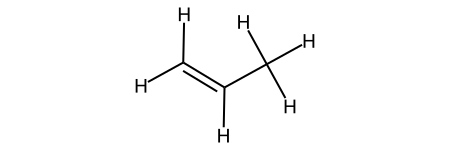

In [2]:
compounds = [
    ("A01_ethene",   0, 0),
    ("A02_propene",  0, 200),
    ("A03_butene",   0, 0),
    ("I01_ch2nh2",   1, 0),
]

d_filter = {"[#6][#1]": 3.5, "[*]~[*]": 4.0}
l_ds = []
removed_points = {}

for name, charge, frame in compounds:
    # load shnitsel-data datasets (https://doi.org/10.5281/zenodo.15482819)
    ds = st.io.read(f"data/{name}_0p50fs_dynamic.nc", kind="shnitsel", input_state_names=["S0", "S1", "S2"])
    # assign rdkit mol object to each dataset
    mol = ds.atXYZ.isel(frame=frame).st.to_mol(charge=charge)
    ds.attrs["mol"] = mol
    #display(ds.attrs["mol"])
    n_before = int(ds.sizes["frame"])

    # remove data points with very long C–H bonds (dissociation)
    ds_filter = ds.st.filter_by_length(search_dict=d_filter, units='bohr', mol=None)
    n_after = int(ds_filter.sizes["frame"])
    removed_points[name] = n_before - n_after

    l_ds.append(ds_filter)

for name, n_removed in removed_points.items():
    print(f"- {name[0:3]}: {n_removed} frames removed")

l_ds[1].mol

## 2) Computing Descriptors for common substructures

In the next step, we **flag a common substructure** that all molecules share, namely the central double bond and the relative position of the protons defining the type of isomer (for butene). This flagging identifies which substructure is considered in the subsequent analysis.

### 2.1) Selecting a substructure

There ate two main strategies to select a substructure of interest for further processing:

- provide a SMARTS
- identify the maximum common substructure

<details>
<summary><strong>Example: Maximum common substructure of A01 and A03</strong></summary>
<br>
The following example will find the maximum common substructure shared between ethene and butene:
<br>

```python
from shnitsel.geo.analogs import combine_analogs
compounds = [l_ds[0], l_ds[2]]
comb = combine_analogs(compounds)

# The following will show the matched substructures, namely HC=CH parts:
[display(mol) for mol in comb.mols]
```
</details>
<br>

In the following, we employ the `combine_analogs` function, to account for the central HC=CH or HC=N<sup>+</sup>H structural fragment using the SMARTS `[#1][#6,#7]=[#6][#1]`, which covers both possible cases.


In [8]:
from importlib import reload

[2, 0, 5, 1, 3, 4]


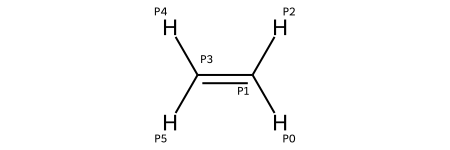

[3, 1, 5, 0, 2, 4]


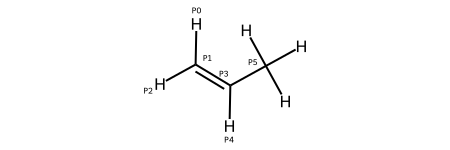

[0, 1, 7, 2, 8, 3]


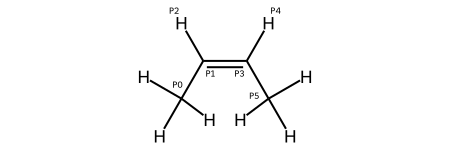

[3, 1, 4, 0, 2, 5]


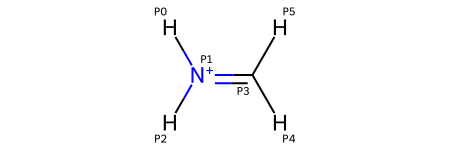

In [11]:
# TODO: Get 6-atom analogs in consistent order
from shnitsel.geo.analogs import combine_analogs
reload(st.geo.analogs)
names=['A01', 'A02', 'A03', 'I01']
smarts_share = '[#6,#1][#6,#7]([#1])=[#6]([#1])[#6,#1]'
# smarts_share = '[#1][#6,#7]=[#6][#1]'
ds_comb_substruc = combine_analogs(l_ds, smarts=smarts_share, names=names, vis=True)

# for i, _ in enumerate(names):
#     display(ds_comb_substruc.mols.item(i))

### 2.2) Calculate descriptors

Upon creating the dataset from the matching substructures of all compounds, we can now compute descriptors. Note, the atom numbering was adjusted, so that we can use descriptors that are sensitive to permutation. Since we only searched for 4 atoms in common, the bats, i.e. bonds, angles torsion would only yield 6 descriptors ($3\cdot 4 - 6 = 6$). Similarly, there are 6 pairwise distances in the molecule ($\frac{1}{2}\cdot 4\cdot(4-1) = 6$).

One could apply the seperate functions `subtract_combinations`, `center`, and `norm` to obtain the pairwise distances, subtract the mean and normalize the features. This is also wrapped in a pipeline within the `get_standardized_pairwise_dists` function provided in `shnitsel.analyze.generic`, which we will use in the following. Note, we have to transpose the resulting array, as the PCA requires the data in shape (frames, descriptors).


INFO: Dimension atomcomb is being generated.
INFO: Dimension atomcomb is being generated.


sweeping clock from -20°
swept to -60°


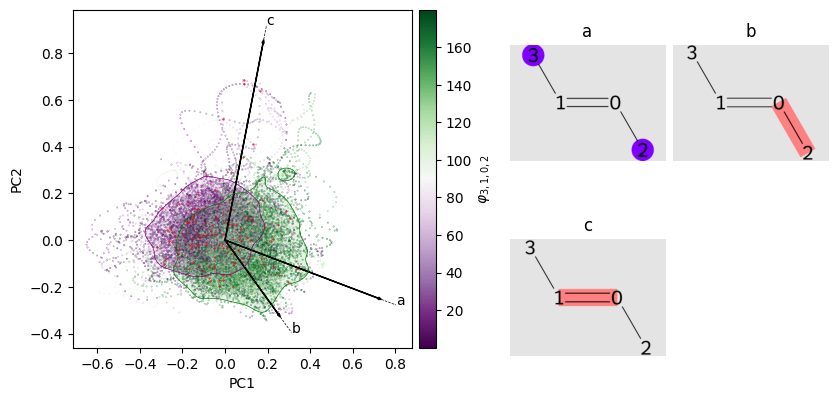

In [5]:
from shnitsel.vis.plot import biplot_kde

ds_a03 = ds_comb_substruc.sel(compound='A03')
kde_data = biplot_kde(ds_a03, 3, 1, 0, 2, nbins=3, mean=True, scatter_color='geo', geo_filter=[(0,30),(150,180)])

INFO: Dimension atomcomb is being generated.
INFO: Dimension atomcomb is being generated.


sweeping clock from -20°
swept to -60°


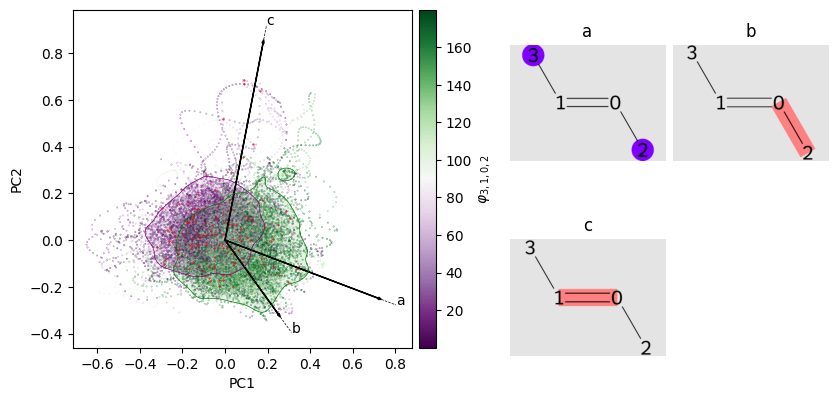

In [6]:
kde_data = biplot_kde(ds_a03, 3, 1, 0, 2, nbins=3, mean=True, scatter_color='geo', geo_filter=[(0,30),(150,180)])

In [7]:
# compute descriptor for all molecules:
pwdists = ds_comb_substruc.atXYZ.st.pwdists(mean=True).transpose('frame', 'atomcomb')
pwdists.sizes

INFO: Dimension atomcomb is being generated.


Frozen({'frame': 99797, 'atomcomb': 6})

## 3) Compare Compounds

To visually compare the **geometrical space** explored during the photoinduced dynamics of **A01**, **A02**, **A03**, and **I01**, we use **principal component analysis (PCA)** to reduce the six features to **two dimensions**.

For convenience, we store the PCA results in a `DataArray`. The workflow is as follows:

1. **Initial PCA across all compounds:** We create a temporary `DataArray` where PCA is computed over the combined data of all compounds using `st.analyze.pca.pairwise_dists_pca`. This gives an initial global view of the data in the reduced space.

2. **Reference PCA using A03:** Next, we perform PCA **only on the data for A03**.  

3. **Project the other compounds:** The data for the other compounds (**A01**, **A02**, **I01**) is then **projected onto the principal axes defined by A03**.  

This approach ensures that the PCA axes are consistent with **A03**, while still allowing the other compounds to be compared in the same reduced space.

In [8]:
pwdists = ds_comb_substruc.atXYZ.st.pwdists(mean=True)

# perform PCA only for compound A03
res_pca_a03 = pwdists.sel(compound='A03').st.pca('atomcomb')

# project all other compounds on PCs of A03
ds_pca = res_pca_a03.st.use_to_transform(pwdists)
ds_pca.sizes

INFO: Dimension atomcomb is being generated.


Frozen({'frame': 99797, 'PC': 2})

To illustrate the dynamics of the compounds in PCA space, we first **compute the dihedral angle** and **length of the double bond** of the four atoms relevant for isomerization in butene and store it in the dataset:

In [9]:
# for plotting purposes we add information on the dihedral angle of the four atoms (defining isomerization for butene)
ds_pca['dih'] = ds_comb_substruc.atXYZ.st.dihedral(3, 1, 0, 2, deg=True)
ds_pca['dist'] = ds_comb_substruc.atXYZ.st.distance(0, 2) # CH distance

Next, we group the dataset by compound and trajectory ID for easier plotting. We then create a subplot mosaic to show each compound separately. For each trajectory, the PCA projections (PC1 *vs* PC2) are plotted in light gray. Finally, the trajectories of each individual compopund are highlighted.

For **A03** color is distinguished based on the final dihedral angle: if < 70° (E-isomer) it is shown in yellow, and if > 110° (Z-isomer) it is shown in blue. 

Text(0.02, 0.5, 'PC2')

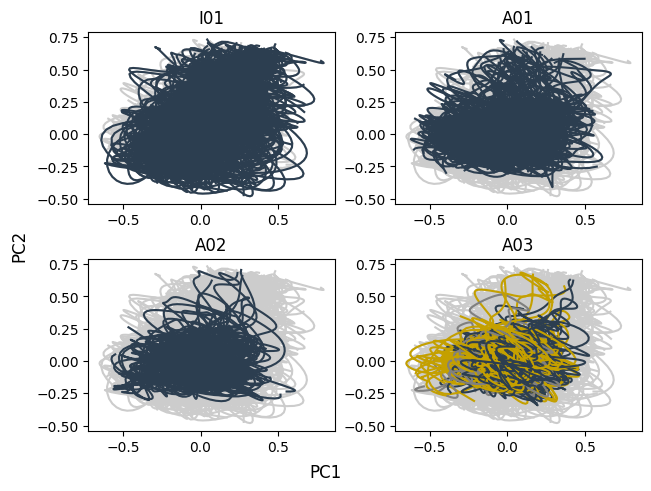

In [10]:
# group dataset by compounds and trajids
ds_grouped = st.data.multi_indices.mgroupby(ds_pca, ['compound', 'trajid'])

fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')
for name, ax in axs.items():
    ax.set_title(name)
    for (compound, trajid), traj in ds_grouped:
        ax.plot(traj[:,0], traj[:,1], c='#ccc', rasterized=True)

for (compound, trajid), traj in ds_grouped:
    dih_end = traj.dih.values[-1]
    if compound == 'A03':
        c = '#C4A000' if dih_end < 70 else '#2c3e50' if dih_end > 110 else 'gray'
    else:
        c = '#2c3e50'
    axs[compound].plot(traj[:,0], traj[:,1], c=c, rasterized=True)

fig.supxlabel('PC1')
fig.supylabel('PC2')
#fig.savefig("PCA_across_compounds_all.pdf", dpi=300)

For comparison, we can also visualize the space spanned by two internal coordinates, e.g. the dihedral angle in the molecule and the length of the central double bond.
These can be e.g. explicitly flagged by smarts and calculated using the `get_bond_torsions` and `get_bond_lengths` functions of the `shnitsel.geo.geocalc` module:

Text(0.02, 0.5, '$\\varphi_{HC=XH}$ / °')

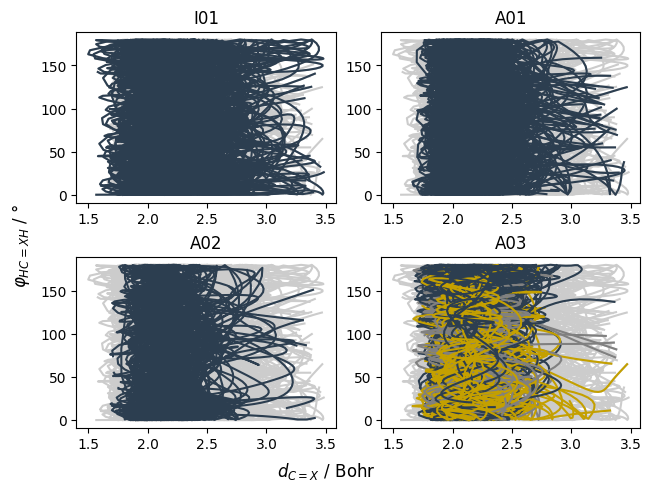

In [11]:
# group dataset by compounds and trajids
ds_grouped = st.data.multi_indices.mgroupby(ds_pca, ['compound', 'trajid'])

fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')
for name, ax in axs.items():
    ax.set_title(name)
    for (compound, trajid), traj in ds_grouped:
        ax.plot(traj.dist, traj.dih, c='#ccc', rasterized=True)

for (compound, trajid), traj in ds_grouped:
    dih_end = traj['dih'].isel(frame=-1)
    if compound == 'A03':
        c = '#C4A000' if dih_end < 70 else '#2c3e50' if dih_end > 110 else 'gray'
    else:
        c = '#2c3e50'
    axs[compound].plot(traj.dist, traj.dih, c=c, rasterized=True)

fig.supxlabel('$d_{C=X}$ / Bohr')
fig.supylabel('$\\varphi_{HC=XH}$ / °')
#fig.savefig("dist_dih_across_compounds_filtered.pdf", dpi=300)

From the second plot it is easy apparent, that generally C=N bonds can be shorter than C=C bonds and that for all molecules all torsion angles between 0 and 180° are visited, i.e. that there is hydrogen-out-of-plane motion and actualy twisting around the C=C or C=N bond.
